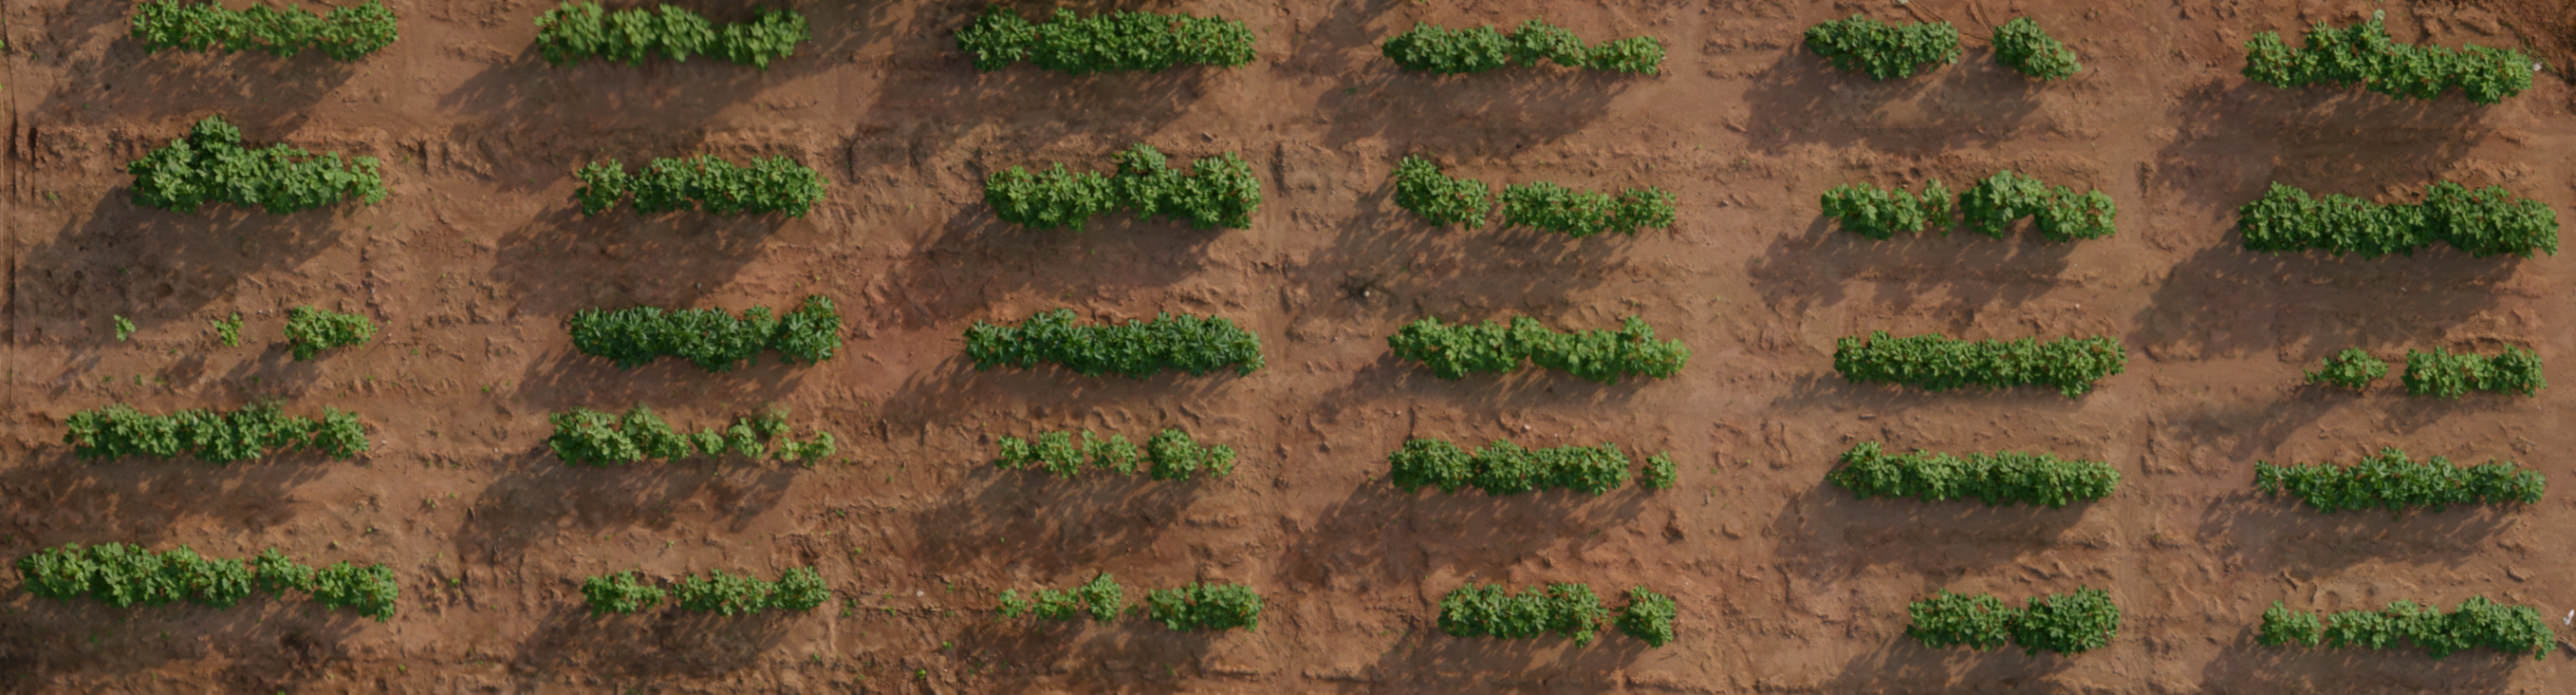

In [3]:
import cv2
from PIL import Image

# Load the image.
field_image = cv2.imread("2022-e-field.png")
field_image = cv2.cvtColor(field_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(field_image))

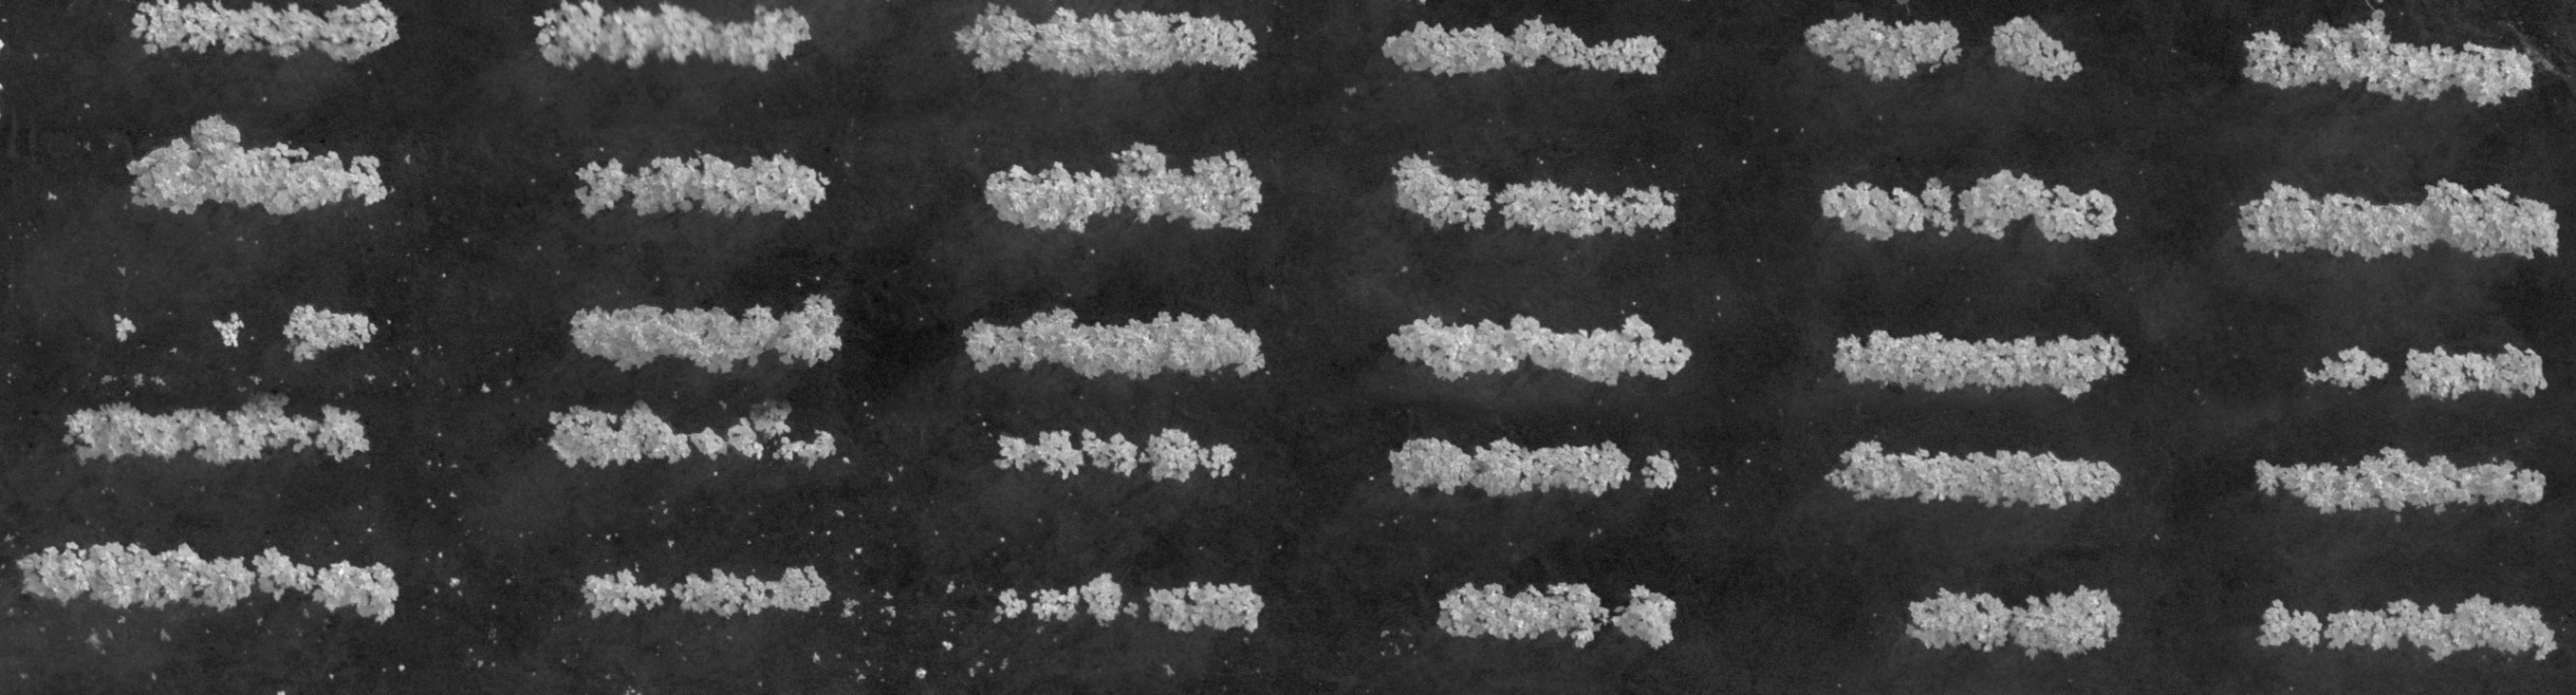

In [9]:
import numpy as np

# Compute excess green mask.
field_float = field_image.astype(np.float32)
r = field_float[..., 0]
g = field_float[..., 1]
b = field_float[..., 2]
excess_green = 2 * g - r - b
excess_green -= excess_green.min()
excess_green /= excess_green.max()
excess_green = (excess_green * 255).astype(np.uint8)

# Display the excess green.
display(Image.fromarray(excess_green))

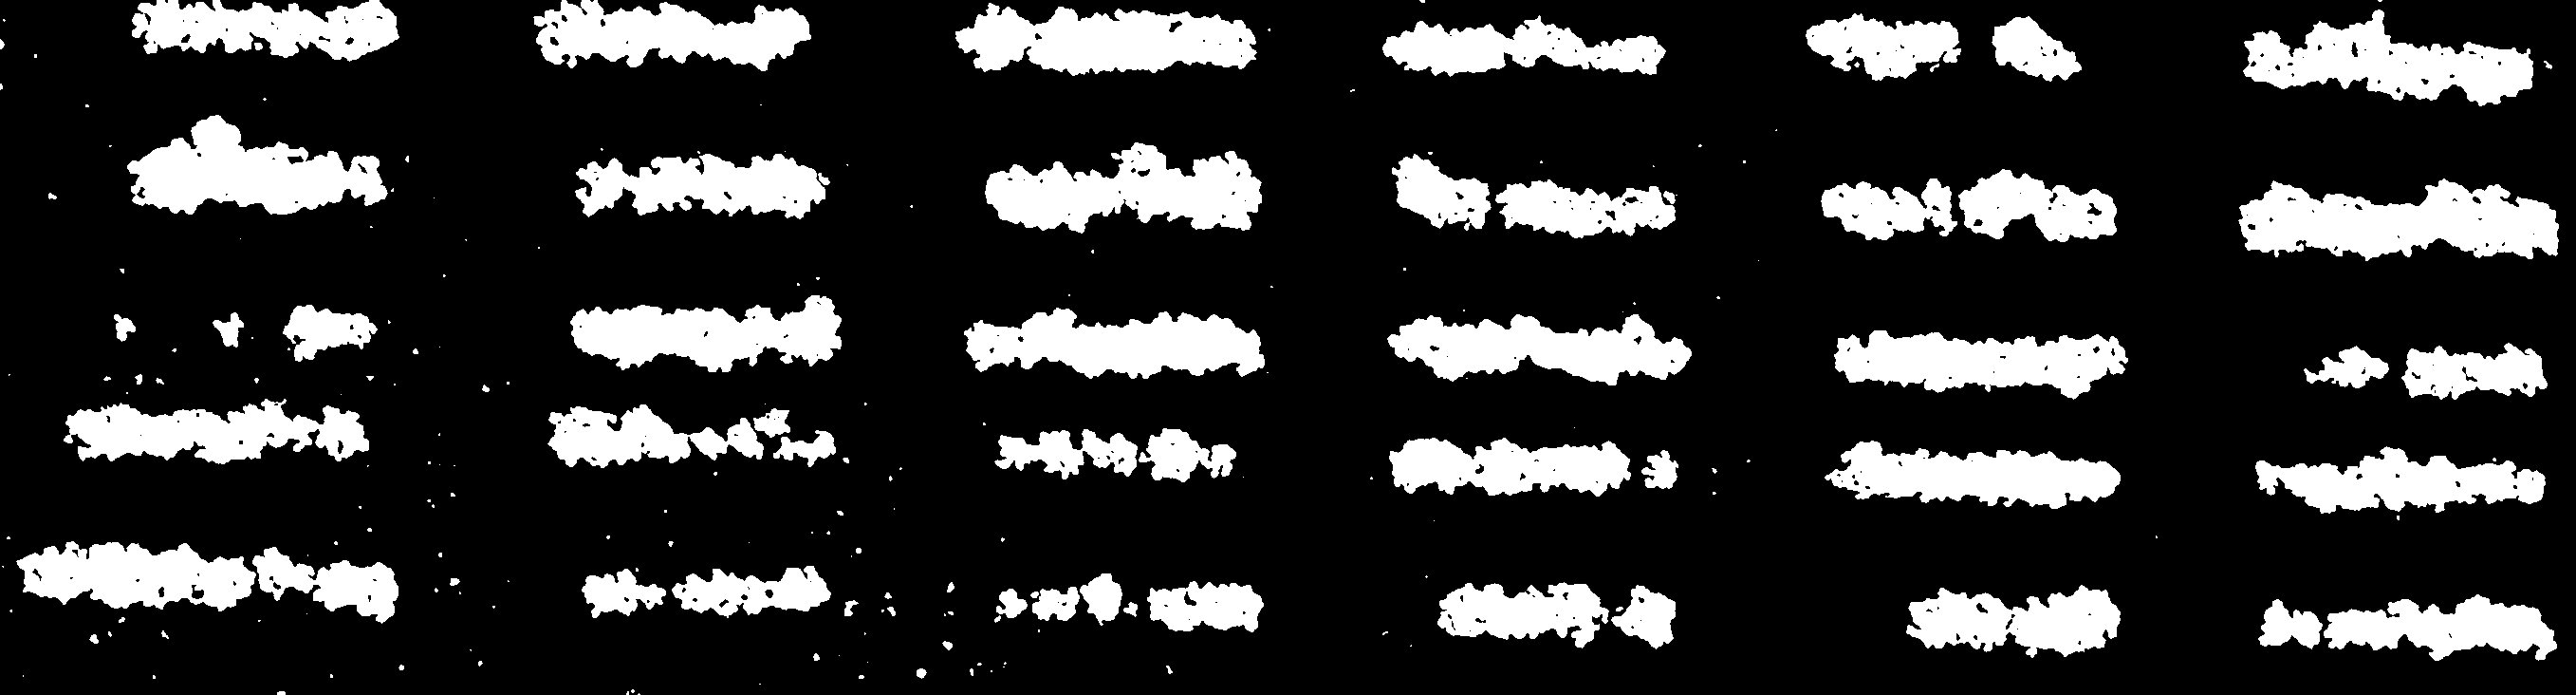

In [10]:
# Binarize the excess green.
excess_green_blur = cv2.GaussianBlur(excess_green, (5, 5), 0)
_, excess_green_bin = cv2.threshold(excess_green_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

display(Image.fromarray(excess_green_bin))

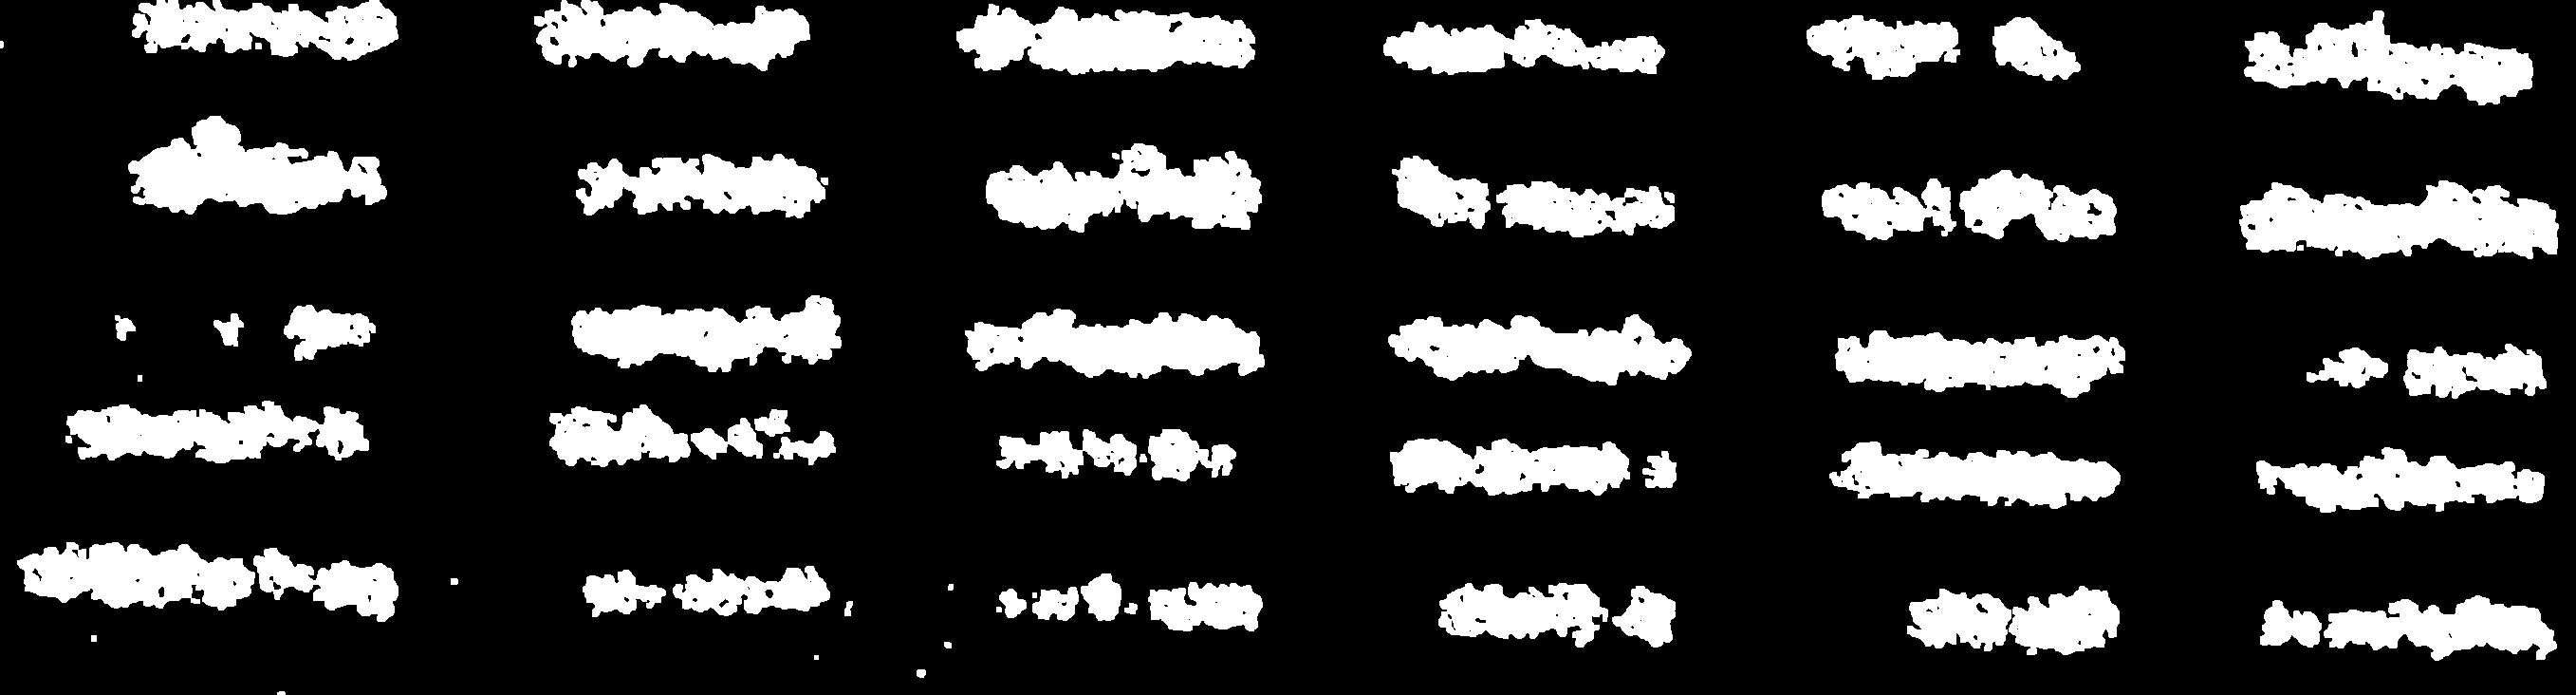

In [14]:
# Open to remove noise.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
excess_green_denoised = cv2.morphologyEx(excess_green_bin, cv2.MORPH_OPEN, kernel)

display(Image.fromarray(excess_green_denoised))

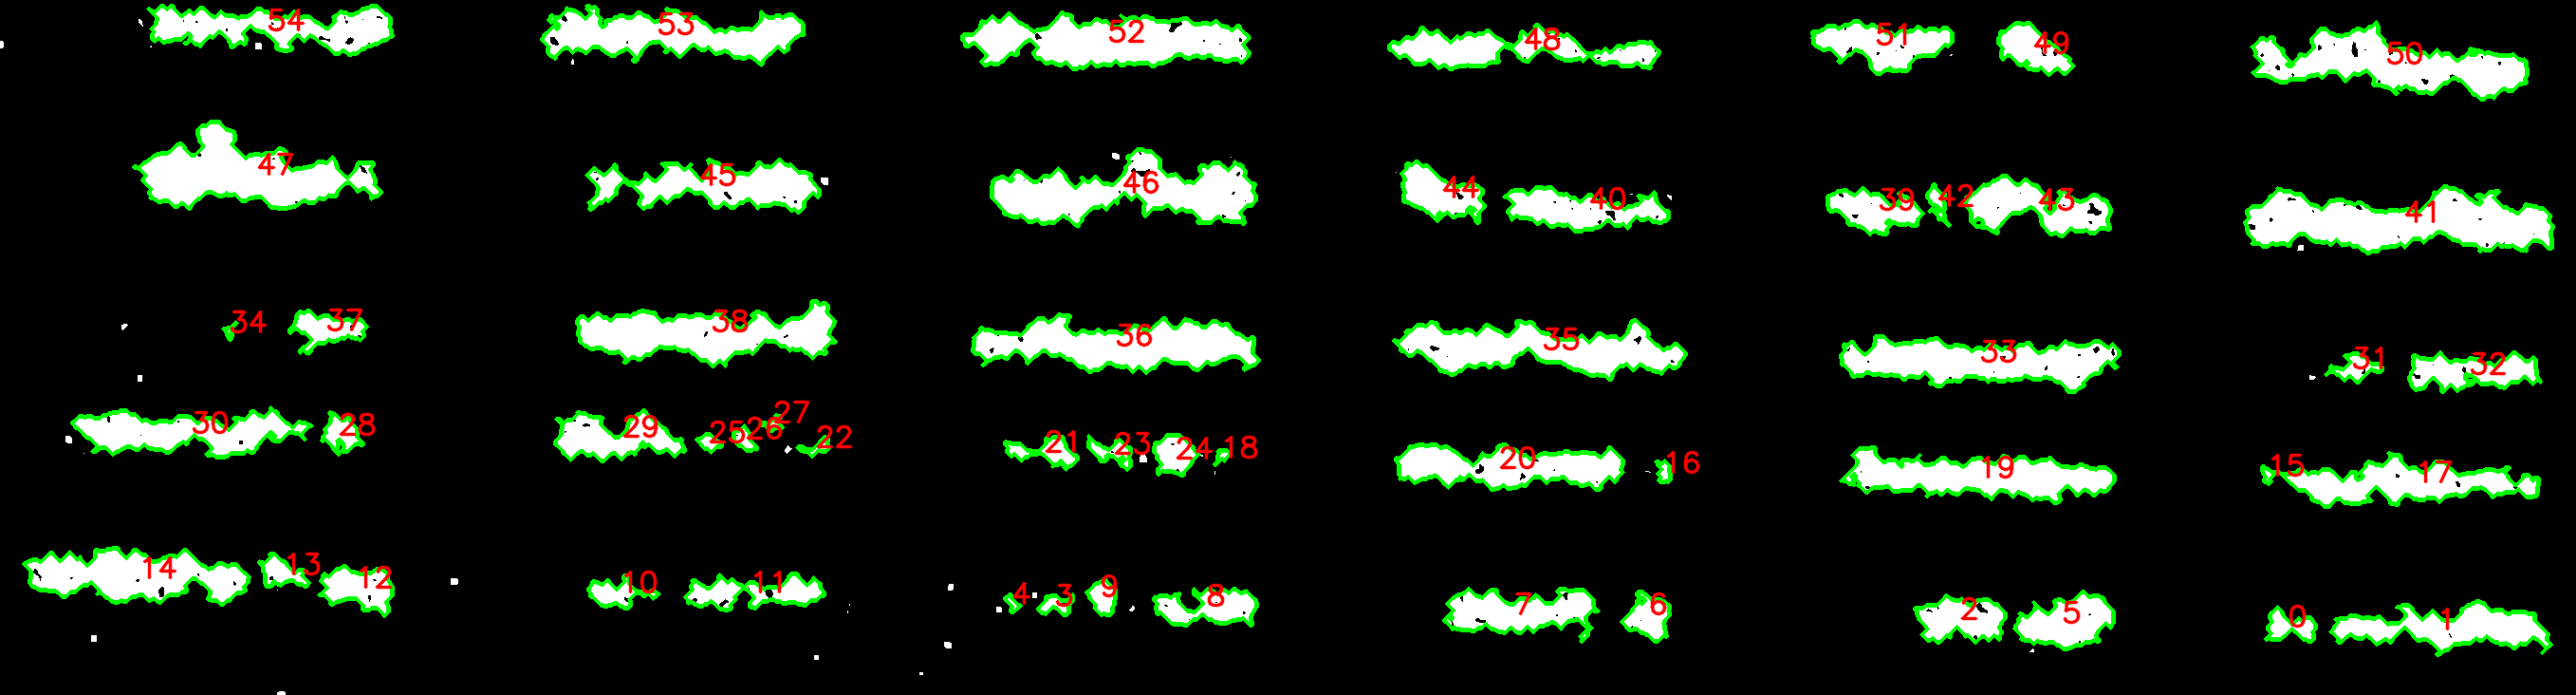

In [40]:
# Find contours.
contours, _ = cv2.findContours(excess_green_denoised, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Remove small ones.
big_contours = list(filter(lambda c: cv2.contourArea(c) > 50, contours))

contour_output = cv2.drawContours(np.stack([excess_green_denoised] * 3, axis=2), big_contours, -1, (0, 255, 0), 3)

# Assign numbers to each contour.
for i, contour in enumerate(big_contours):
    contour = np.squeeze(contour)
    centroid = np.mean(contour, axis=0).astype(int)
    cv2.putText(contour_output, str(i), centroid, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

display(Image.fromarray(contour_output))

In [42]:
# This is the association between plot numbers and contour numbers.
plots_to_contour = [
    # Row 1
    [54], [53], [52], [48], [51, 49], [50],
    # Row 2
    [41], [39, 42, 43], [40, 44], [46], [45], [47],
    # Row 3
    [34, 37], [38], [36], [35], [33], [31, 32],
    # Row 4
    [15, 17], [19], [20, 16], [21, 23, 24, 18], [29, 25, 26, 27, 22], [30, 28],
    # Row 5
    [14, 13, 12], [10, 11], [4, 3, 9, 8], [7, 6], [2, 5], [0, 1]
]

# Load the count data.
%reload_kedro
engr_counts = catalog.load("2022_engr_field_counts")
engr_counts

2024-02-08 11:01:32,674 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/cotton_flower_mot.
To set a different path, run '%reload_kedro <project_root>'
2024-02-08 11:01:32,676 - py.warnings - WARNING - /home/daniel/git/cotton_flower_mot/.venv/lib/python3.10/site-packages/kedro/framework/startup.py:98: DeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2024-02-08 11:01:32,821 - kedro.io.core - WARNING - 'version' attribute removed from data set configuration since it is a reserved word and cannot be directly specified
2024-02-08 11:01:32,822 - kedro.io.core - WARNING - 'version' attribute removed from data set configuration since it is a reserved word and cannot be directly specified
2024-02-08 11:01:32,823 - kedro.io.core - WARNING - 'version' attribute removed from data set configuration since it is a reserved word and cannot be directly specified
2024-02-08 11:01:32,823 - kedro.io.core - WARNING - '

2022-08-23  2022-08-31  2022-09-07  2022-09-15
0            4           5           3           4
1            6           4           5           1
2            7           5           4           5
3            5          12          13           4
4           10          10           7           6
5            9           8          10           7
6           22          13           4           5
7            1           2           4           5
8           11           6           7           8
9            7           3           5           9
10           6           7           5           6
11           5           1           2           1
12           3           1           9           3
13           7          11           8           7
14          11           8           5          11
15           5           2           1           5
16          15          10           8           4
17           3           7          10           7
18           6          10           7           5
19           5           0           1           8
20          12           6          11           6
21           4           5           8           3
22           0           8           7           7
23           5           9          10          11
24           5           9           6           3
25           5           7          11           7
26           7           7          10           7
27          10           9          10           5
28           2          19          10           2
29           8           7           4           8

In [126]:
from PIL import ImageDraw, ImageFont
from typing import Tuple, Iterable

START_COLOR = [255, 255, 255]
END_COLOR = [66, 168, 3]

KEY_FONT = ImageFont.truetype("../fonts/VeraBd.ttf", 24)
TITLE_FONT = ImageFont.truetype("../fonts/VeraBd.ttf", 48)

# Compute normalized count values.
engr_counts_norm = engr_counts / engr_counts.max().max()

def get_color(count_norm: float) -> Tuple[int, int, int]:
    # Gets the RGB color value for a particular normalized count.
    color = []
    for i in range(len(START_COLOR)):
        color.append(np.interp(count_norm, [0.0, 1.0], [START_COLOR[i], END_COLOR[i]]))
    return tuple([int(c) for c in color])


def draw_key() -> Image.Image:
    # Draws the key to use.
    key_height = field_image.shape[0]
    # Generate the gradient.
    gradient = np.linspace(END_COLOR, START_COLOR, key_height).astype(np.uint8)
    gradient = gradient.reshape((-1, 1, 3))
    gradient = np.tile(gradient, (1, 50, 1))
    gradient = Image.fromarray(gradient)
    
    key = Image.new("RGB", (100, field_image.shape[0]), color=(255, 255, 255))
    key.paste(gradient, (0, 0))
    
    # Draw the markings.
    artist = ImageDraw.Draw(key)
    regular_counts = np.linspace(0, engr_counts.max().max(), 10).astype(int)
    regular_counts_y = np.linspace(key_height, 0, 10).astype(int)
    for y, count in zip(regular_counts_y, regular_counts):
        artist.text((60, y), str(count), fill=(50, 50, 50), font=KEY_FONT)
    
    return key


figure_key = draw_key()
    

def draw_figure(counts: Iterable[float], title: str = "Plot Counts") -> Image.Image:
    figure = Image.fromarray(np.ones_like(field_image) * 255)
    artist = ImageDraw.Draw(figure)
    
    for count, contour_idxs in zip(counts, plots_to_contour):
        color = get_color(count)
        for contour_i in contour_idxs:
            contour = big_contours[contour_i]
            # Draw the contour in the correct color.
            artist.polygon(contour.flatten().tolist(), fill=color, outline=(50, 50, 50))
        
    # Box the plots.
    artist.rectangle([0, 0, figure.width, figure.height], outline=(50, 50, 50), width=2)
    # Add the key.
    figure_with_key = Image.new("RGB", (figure.width + 50 + figure_key.width, figure.height + 100), color=(255, 255, 255))
    figure_with_key.paste(figure, (0, 100))
    figure_with_key.paste(figure_key, (figure.width + 50, 100))
    
    # Add the title.
    artist = ImageDraw.Draw(figure_with_key)
    artist.text((figure_with_key.width / 2, 50), title, fill=(50, 50, 50), font=TITLE_FONT, anchor="mm") 
    
    return figure_with_key
        

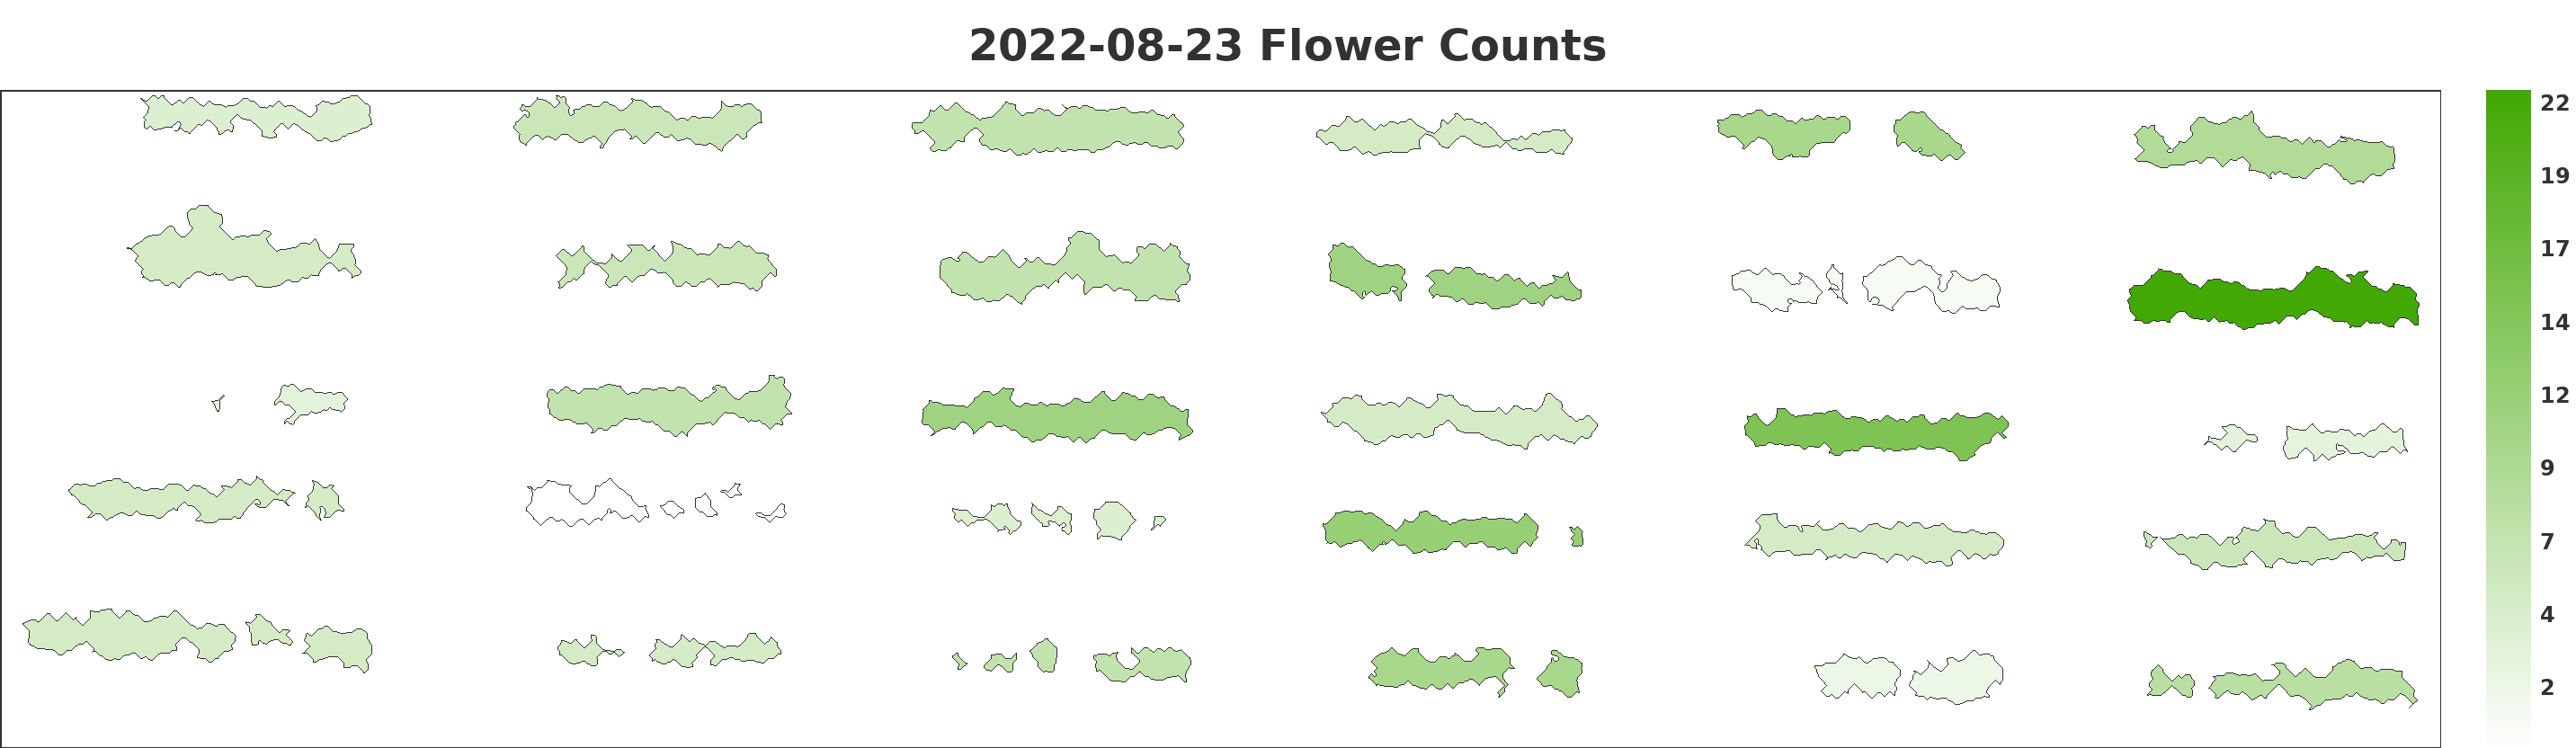

In [127]:
figure_8_23 = draw_figure(engr_counts_norm["2022-08-23"], title="2022-08-23 Flower Counts")
display(figure_8_23)

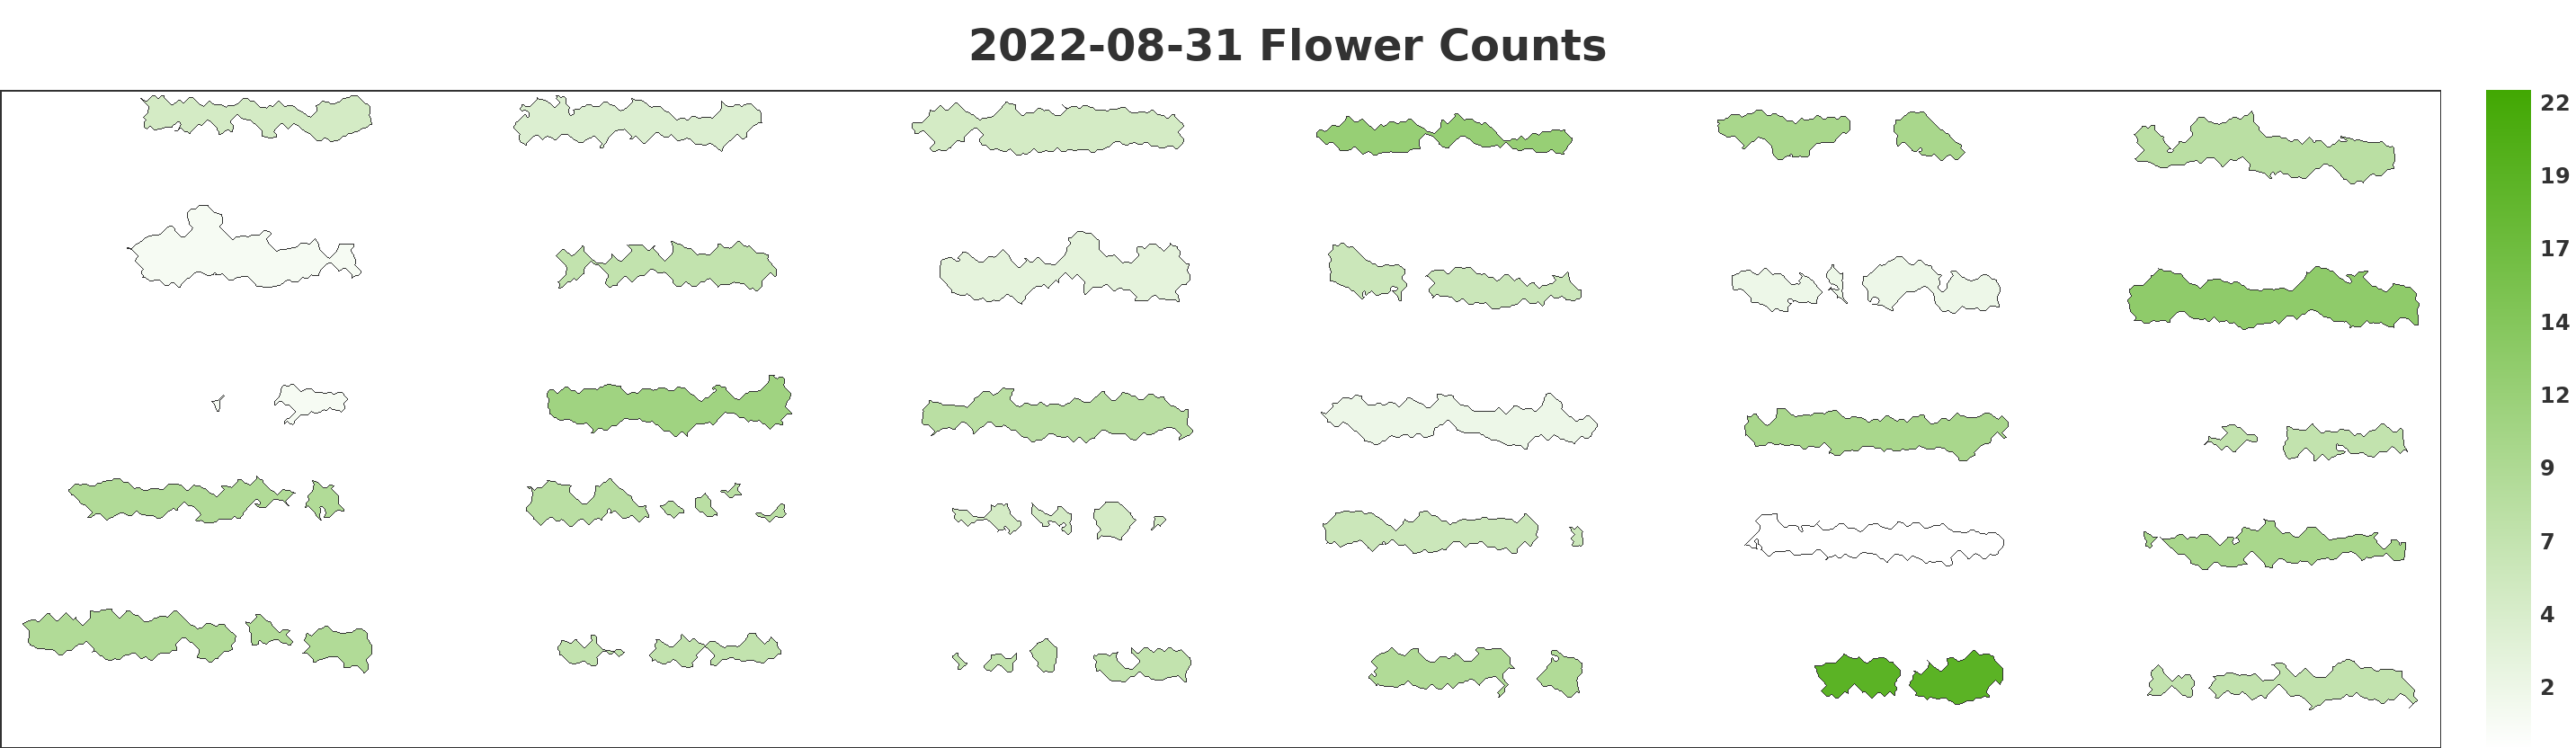

In [128]:
figure_8_31 = draw_figure(engr_counts_norm["2022-08-31"], title="2022-08-31 Flower Counts")
display(figure_8_31)

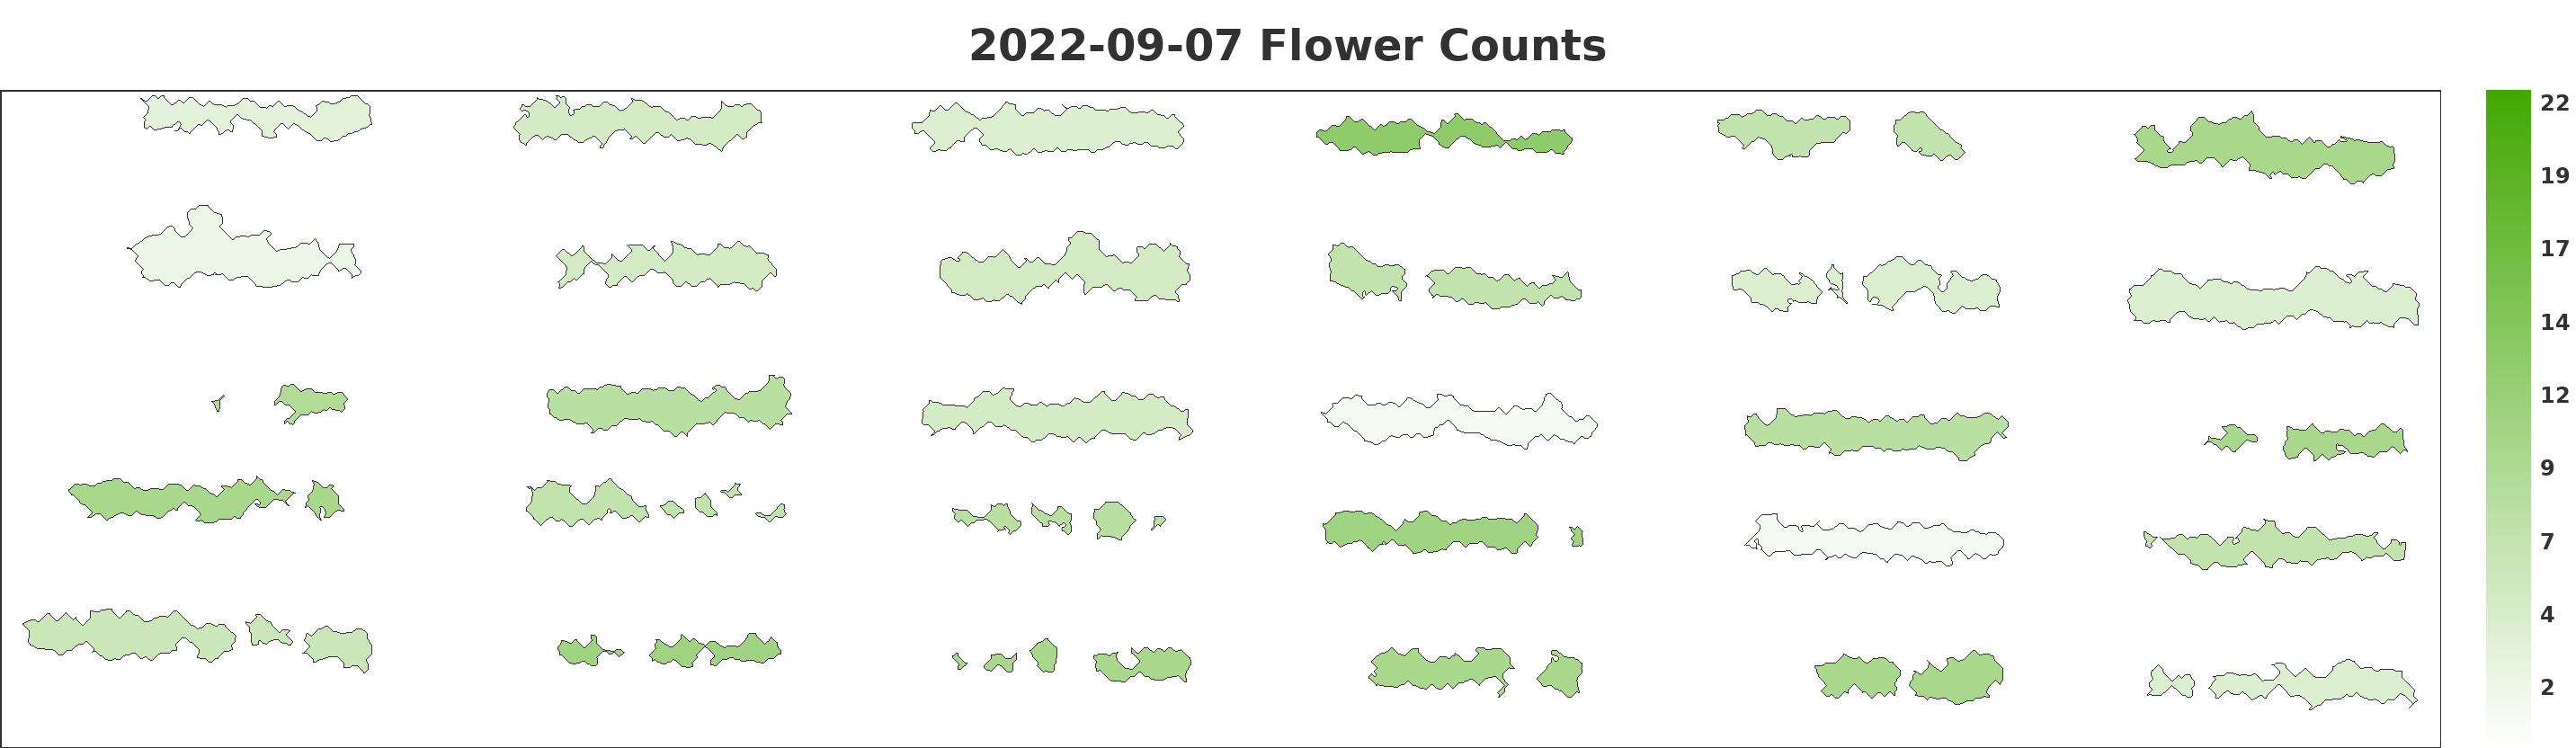

In [129]:
figure_9_07 = draw_figure(engr_counts_norm["2022-09-07"], title="2022-09-07 Flower Counts")
display(figure_9_07)

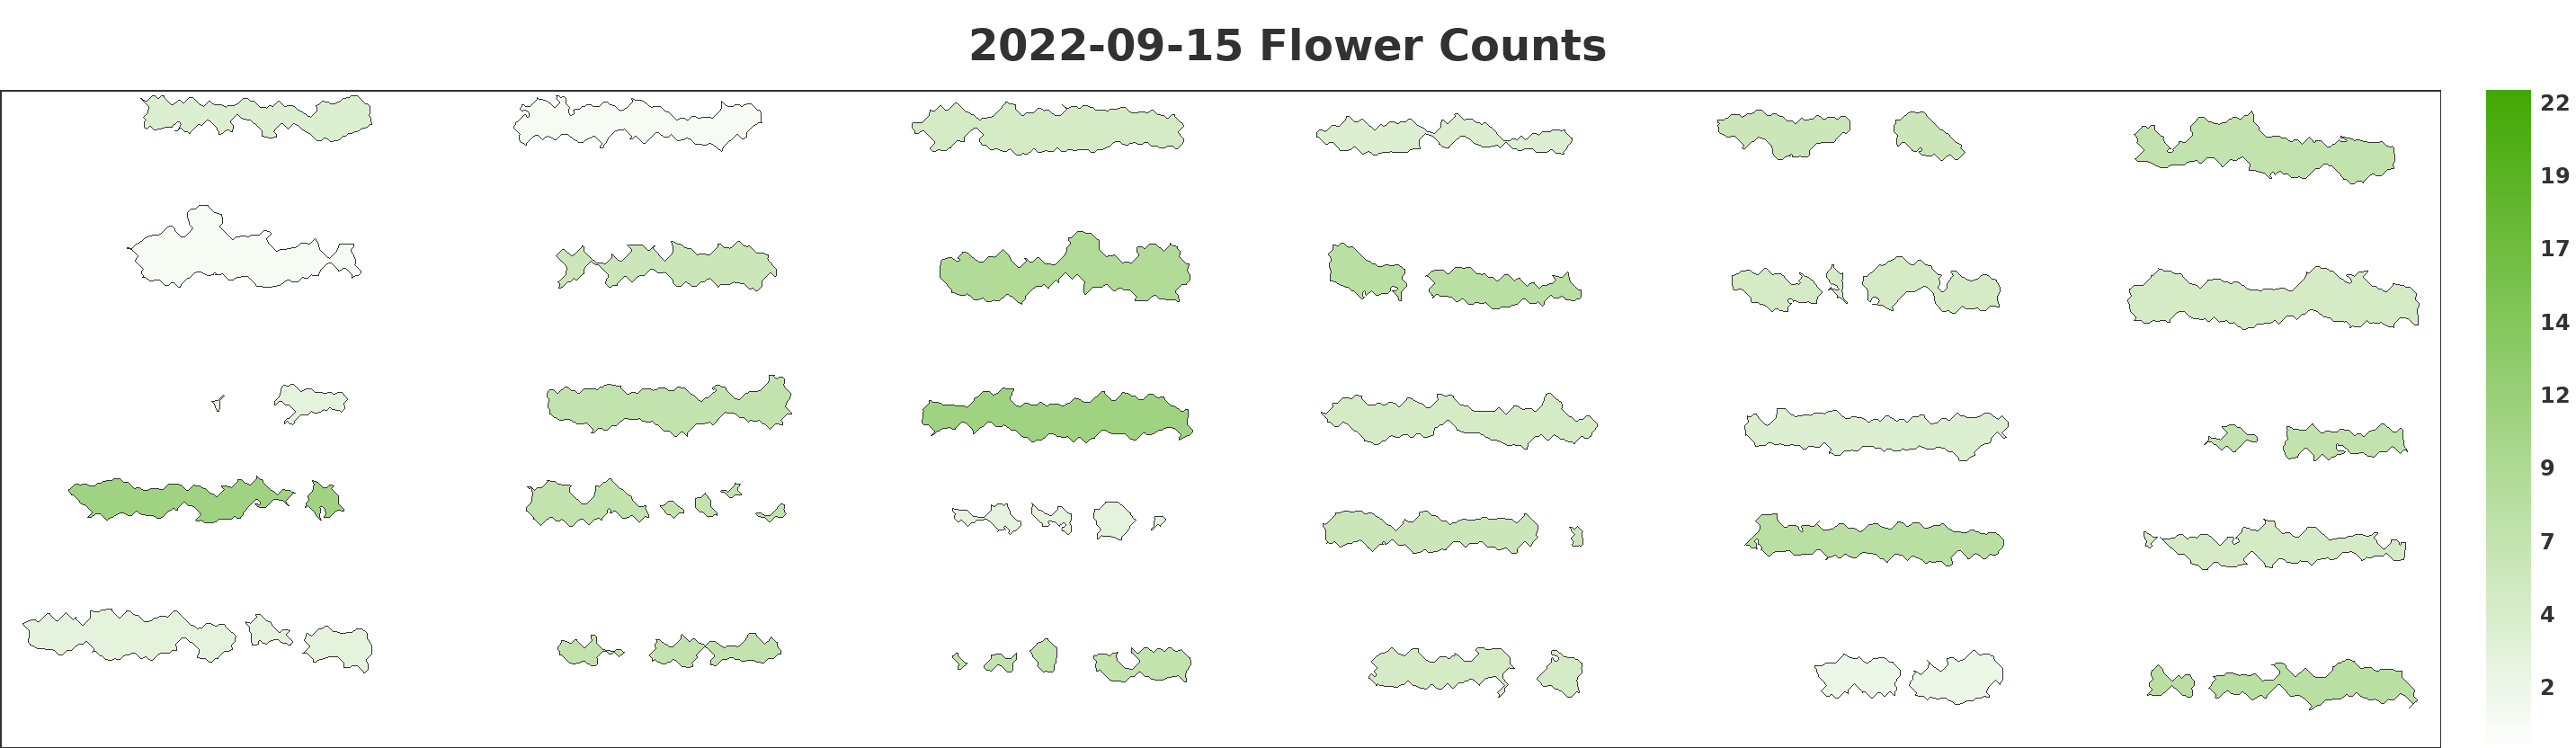

In [130]:
figure_9_15 = draw_figure(engr_counts_norm["2022-09-15"], title="2022-09-15 Flower Counts")
display(figure_9_15)